In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pydicom
import nibabel as nib
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

from IPython.display import display, clear_output

import os
import os.path
import math

from scipy.ndimage import affine_transform
import scipy.ndimage

def plot_images(img_stack, *, labels=None, figdim=5, colormap=plt.cm.gray, **imshowkwarg):
    """
    Funzione di utilità per mostrare una grigli di immagini, impostando la lista delle legende
    e, opzionalmente, la colormap che di default è impostata a livelli di grigio
    """    
    nimag = len(img_stack)

    # creiamo il layout
    nrows = 1 if nimag <= 3 else 2 if nimag <= 6 else 3 if nimag <=12 else 4 if nimag <= 16 else 5
    ncols = nimag if nrows == 1 else 2 if nimag == 4 else 3 if nimag <=9 else 4 if nimag <= 16 else 5

    # generiamo la figura con un canvas ce riserva 5x5 pollici a immagine
    # e i riferimenti alle singole immagini
    fig, axs = plt.subplots(nrows,ncols,squeeze=False,figsize=(figdim*ncols, figdim*nrows))
    
    img = 0 # contatore delle immagini

    for r in range(nrows):
        for c in range(ncols):
            # eliminiamo lo stile del grafico
            axs[r, c].tick_params(axis='both',\
                    which='both',\
                    bottom=False,top=False,right=False,left=False,\
                    labelbottom=False,labelleft=False)
            plt.gca().spines['top'].set_visible(False)
            plt.gca().spines['bottom'].set_visible(False)
            plt.gca().spines['left'].set_visible(False)
            plt.gca().spines['right'].set_visible(False)

            # se ci troviamo nella posizione di una
            # immagine allora la mostriamo
            if r*ncols + c < nimag:
                if labels != None:
                    axs[r, c].set_title(labels[img])
            
                axs[r, c].imshow(img_stack[img], cmap=colormap, **imshowkwarg)

                img += 1 # immagine successiva
    
    return axs


In [2]:
dcm_slice = pydicom.dcmread('./Data/Sag_FLAIR+FATSAT_CUBE_3/IM-0021-0069.dcm')
dcm_img = dcm_slice.pixel_array

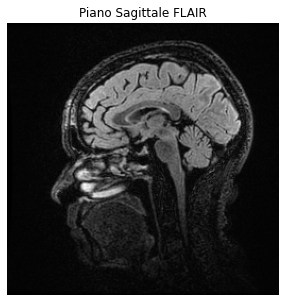

In [3]:
axes = plot_images([dcm_img],labels=['Piano Sagittale FLAIR'])

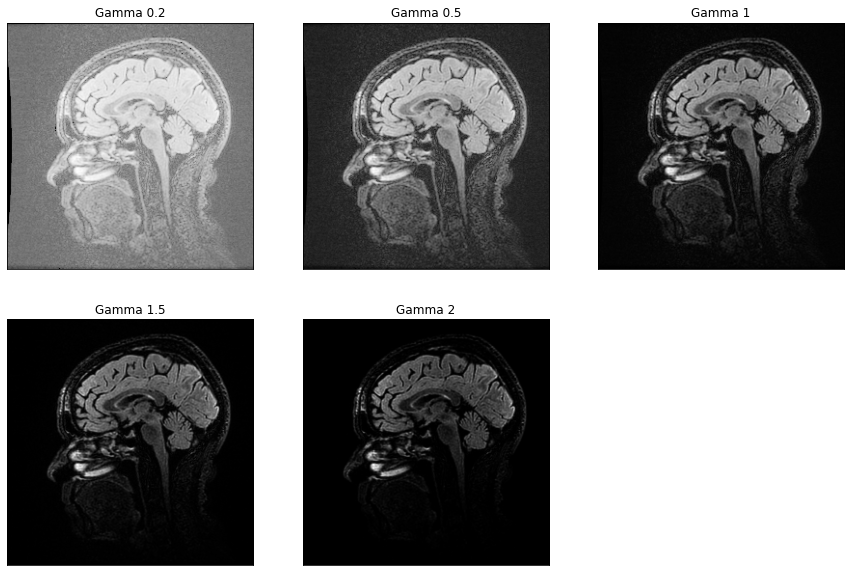

In [4]:
gamma = np.array([0.2, 0.5, 1, 1.5, 2])

gamma_corrected = dcm_img.reshape(1,256,256)**gamma.reshape(5,1,1)


axes = plot_images(gamma_corrected,labels=['Gamma 0.2','Gamma 0.5','Gamma 1','Gamma 1.5','Gamma 2'])

In [5]:
def plot_hist(img):
    dcmin = img.min()
    dcmax = img.max()

    (hist, hist_bins) = np.histogram(img,bins=dcmax-dcmin+1)
    (pdf, pdf_bins) = np.histogram(img,bins=dcmax-dcmin+1,density=True)

    cumulative = np.cumsum(pdf)

    fig, axs = plt.subplots(1,3,figsize=(15,5))

    axs[0].bar(np.arange(len(hist)),hist)
    axs[1].bar(np.arange(len(pdf)),pdf)
    axs[2].plot(cumulative,'r-')

    return (hist, pdf, cumulative)


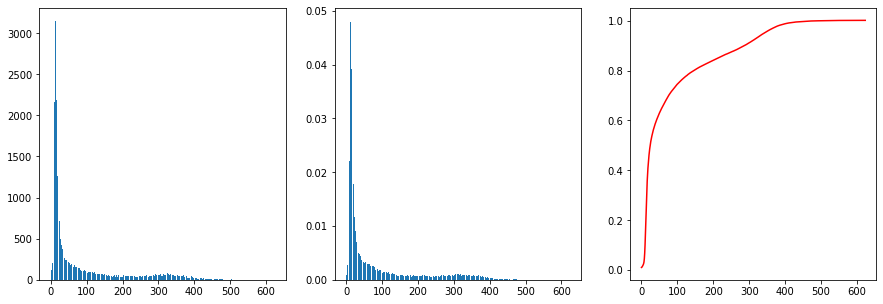

In [6]:
hist, pdf, cumulative = plot_hist(dcm_img)

In [7]:
def hist_equalization(img):

    # definiamo L come il valor massimo dell'immagine di ingresso
    L = img.max()

    # calcoliamo la funzione cumulativa della pdf
    (pdf, pdf_bins) = np.histogram(img,bins=L-img.min()+1,density=True)
    cumulative = np.cumsum(pdf)

    # creiamo la nuova immagine vuota
    out = np.zeros(shape=img.shape,dtype=img.dtype)

    # Calcoliamo i valori dei pixel
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):

            np.put(out,i*img.shape[1]+j,L*cumulative[img[i,j]])
    
    return out

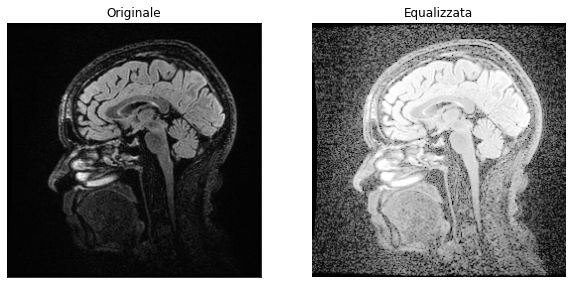

In [8]:
equalized = hist_equalization(dcm_img)

axes = plot_images([dcm_img,equalized],labels=['Originale','Equalizzata'])

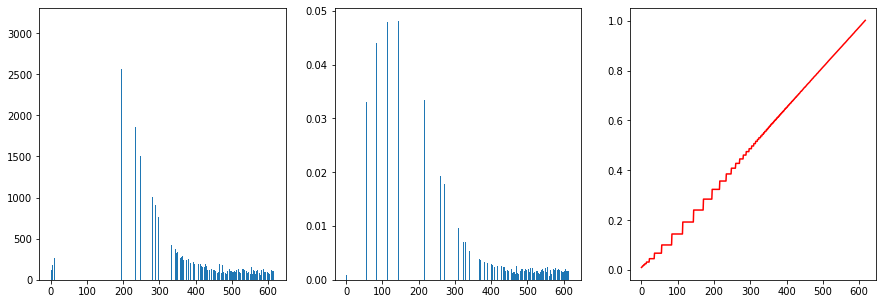

In [9]:
histeq, pdfeq, cumulativeq = plot_hist(equalized)

In [10]:
# Definiamo una serie di trasformazioni
M = np.array([\
    # Traslazione (50, 100)
    [[1.0, 0.0, 50.0],\
     [0.0, 1.0, 100.0],\
     [0.0, 0.0, 1.0]],\
    # Rotazione di 30° positiva
    [[math.cos(math.pi/6.0), -math.sin(math.pi/6.0), 0.0],\
     [math.sin(math.pi/6.0), math.cos(math.pi/6.0), 0.0],\
     [0.0, 0.0, 1.0]],\
    # Scalatura di (0.3, 1.2)
    [[0.3, 0.0, 0.0],\
     [0.0, 1.2, 0.0],\
     [0.0, 0.0, 1.0]],\
    # Scorrimento di (0.3, 0.2)
    [[1.0, 0.3, 0.0],\
     [0.2, 1.0, 0.0],\
     [0.0, 0.0, 1.0]],\
    ])

stack = np.ones((5,dcm_img.shape[0],dcm_img.shape[1]))

stack = stack * dcm_img

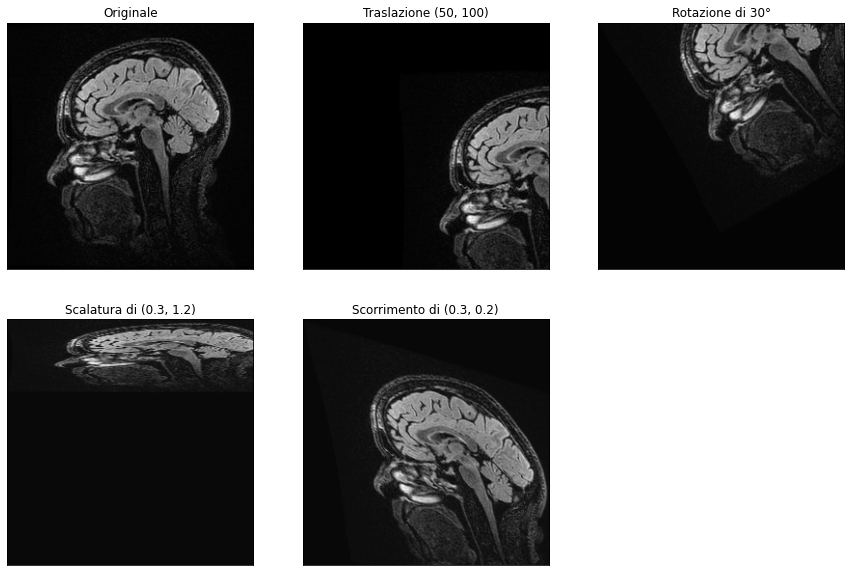

In [11]:
for i in range(1,len(stack)):
    stack[i] = scipy.ndimage.affine_transform(stack[i],np.matrix(M[i-1]).I)

labels = ['Originale', 'Traslazione (50, 100)', 'Rotazione di 30°', 'Scalatura di (0.3, 1.2)', 'Scorrimento di (0.3, 0.2)']

axes = plot_images(stack,labels=labels)

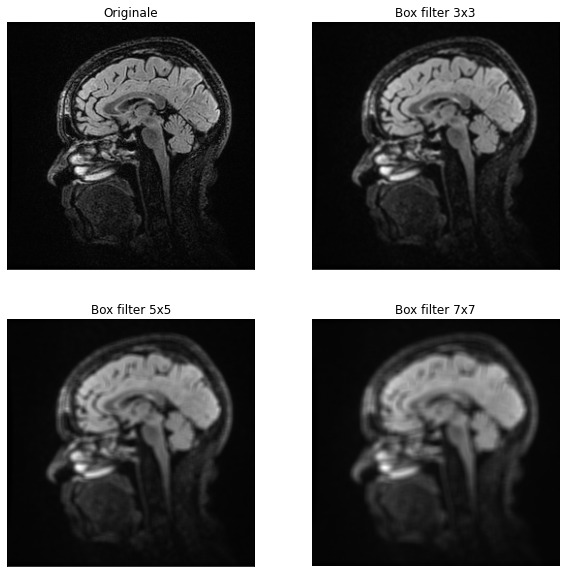

In [12]:
# costruiamo tre box filter

box3 = (1/9)*np.ones((3,3))
box5 = (1/25)*np.ones((5,5))
box7 = (1/49)*np.ones((7,7))

low_pass = np.ones((4,dcm_img.shape[0],dcm_img.shape[1]))

low_pass = low_pass * dcm_img

for i in range(1,len(low_pass)):
    low_pass[i] = scipy.ndimage.convolve(low_pass[i],\
        box3 if i == 1 else box5 if i == 2 else box7)

axes = plot_images(low_pass,\
    labels=['Originale', 'Box filter 3x3', 'Box filter 5x5', 'Box filter 7x7'])

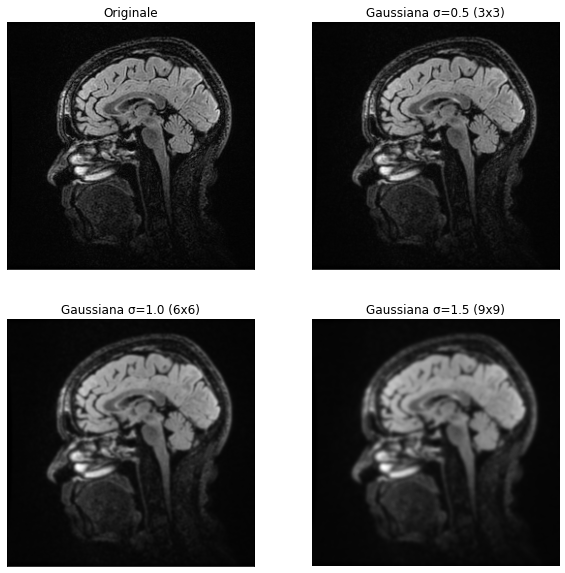

In [13]:
gaussian = np.ones((4,dcm_img.shape[0],dcm_img.shape[1]))

gaussian = gaussian * dcm_img

sigma = [0.5, 1.0, 1.5]

for i in range(1,len(gaussian)):
    gaussian[i] = scipy.ndimage.gaussian_filter(gaussian[i],sigma[i-1])

axes = plot_images(gaussian,\
    labels=['Originale', 'Gaussiana \u03C3=0.5 (3x3)', 'Gaussiana \u03C3=1.0 (6x6)', 'Gaussiana \u03C3=1.5 (9x9)'])


In [27]:
def gausskern(sigma, order=0):

    # Definiamo la dimensione della maschera di convoluzione
    shape = int(sigma*6)
    if( shape % 2 == 0):
        shape += 1
    
    # Creiamo il kernel di uscita con il valore 1 solo nel centro
    out = np.zeros((shape,shape),dtype=float)
    np.put(out,shape*shape//2,1.0)

    out = scipy.ndimage.gaussian_filter(out,sigma=sigma, order=order)

    return out


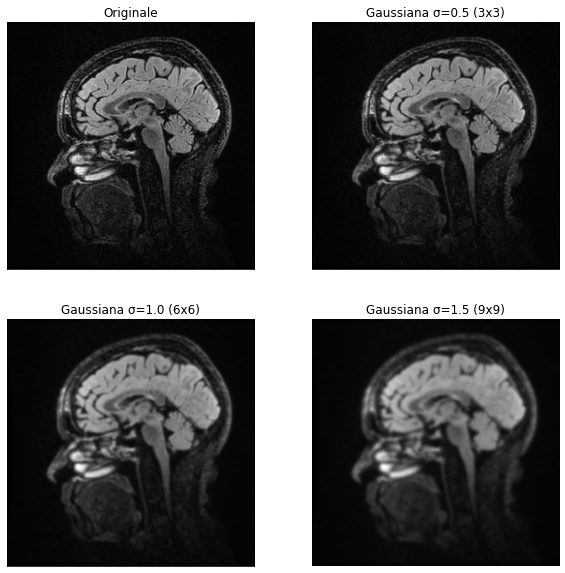

In [28]:
gauss3 = gausskern(0.5)
gauss7 = gausskern(1.0)
gauss9 = gausskern(1.5)

ggkern = np.ones((4,dcm_img.shape[0],dcm_img.shape[1]))

ggkern = ggkern * dcm_img

for i in range(1,len(ggkern)):
    ggkern[i] = scipy.ndimage.convolve(ggkern[i],\
            gauss3 if i ==1 else gauss7 if i ==2 else gauss9, mode='reflect')

axes = plot_images(ggkern,\
    labels=['Originale', 'Gaussiana \u03C3=0.5 (3x3)', 'Gaussiana \u03C3=1.0 (6x6)', 'Gaussiana \u03C3=1.5 (9x9)'])


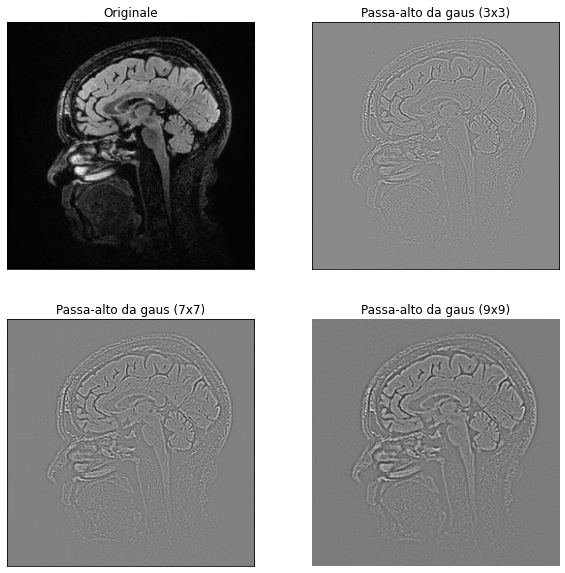

In [16]:
high_pass = np.array(gaussian)

high_pass[1:] = high_pass[0] - high_pass[1:]

axes = plot_images(high_pass,labels=\
    ['Originale', 'Passa-alto da gaus (3x3)', 'Passa-alto da gaus (7x7)', 'Passa-alto da gaus (9x9)'])

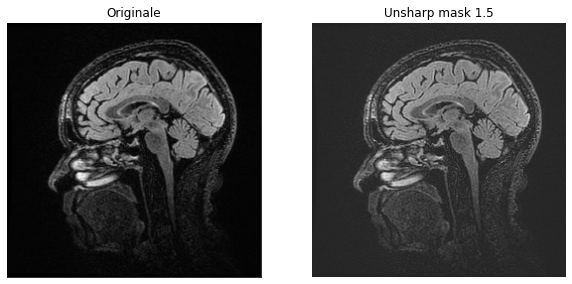

In [17]:
def unsharp_mask(img, alpha, sigma=0.5):

    # calcoliamo l'immagine di blur con una gaussiana di data sigma
    blur = scipy.ndimage.gaussian_filter(img, sigma=sigma)

    return img + alpha * (img - blur)

axes = plot_images([dcm_img, unsharp_mask(dcm_img,1.5)],labels=['Originale', 'Unsharp mask 1.5'])

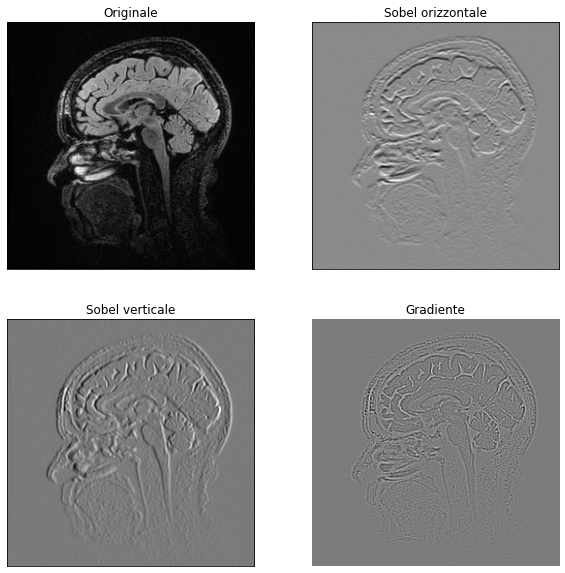

In [26]:
sobel_h = np.array([\
    [-1, -2, -1],\
    [0, 0, 0],\
    [1, 2, 1]])

sobel_v = np.array([\
    [-1, 0, 1],\
    [-2, 0, 2],\
    [-1, 0, 1]])

nabla = np.array([\
    [1, 1, 1],\
    [1, -8, 1],\
    [1, 1, 1]])


sobel_nabla = np.ones((4,dcm_img.shape[0],dcm_img.shape[1]))

sobel_nabla = sobel_nabla * dcm_img

for i in range(1,len(sobel_nabla)):
    sobel_nabla[i] = scipy.ndimage.convolve(dcm_img,sobel_h if i ==1 else sobel_v if i ==2 else nabla, mode='reflect')

axes = plot_images(sobel_nabla,labels=\
    ['Originale', 'Sobel orizzontale', 'Sobel verticale','Gradiente'])

In [38]:
dog_h = gausskern(0.5, order=(1,0))
dog_v = gausskern(0.5, order=(0,1))
log = gausskern(0.5, order=(2,2))

In [40]:
print(dog_h, dog_v, log, sep='\n\n')

[[ 0.04521416  0.33326386  0.04521416]
 [ 0.          0.          0.        ]
 [-0.04521416 -0.33326386 -0.04521416]]

[[ 0.04521416  0.         -0.04521416]
 [ 0.33326386  0.         -0.33326386]
 [ 0.04521416  0.         -0.04521416]]

[[ 1.67247272 -4.06890258  1.67247272]
 [-4.06890258  9.89909611 -4.06890258]
 [ 1.67247272 -4.06890258  1.67247272]]


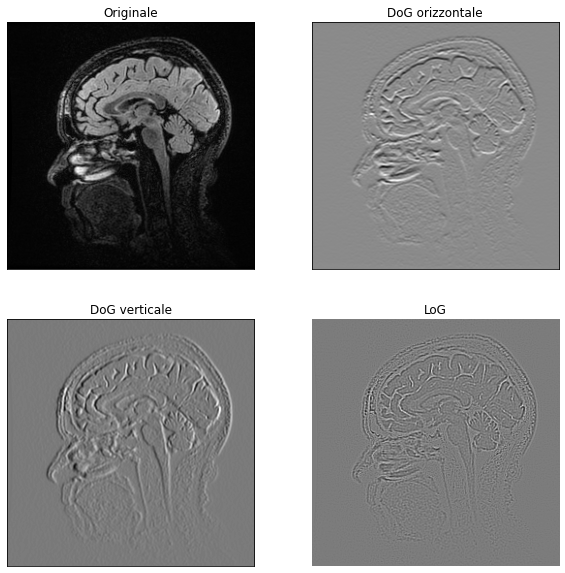

In [41]:
gauss_deriv = np.ones((4,dcm_img.shape[0],dcm_img.shape[1]))

gauss_deriv = gauss_deriv * dcm_img

for i in range(1,len(gauss_deriv)):
    gauss_deriv[i] = scipy.ndimage.convolve(dcm_img,dog_h if i ==1 else dog_v if i ==2 else log, mode='reflect')

axes = plot_images(sobel_nabla,labels=\
    ['Originale', 'DoG orizzontale', 'DoG verticale','LoG'])

In [52]:
g1 = gausskern(0.5)
g2 = gausskern(0.7)

g1pad = np.pad(g1, (1,1), constant_values=0)

dog = g2 - g1pad

np.set_printoptions(precision=3, suppress=True)

print(dog)

[[ 0.     0.002  0.006  0.002  0.   ]
 [ 0.002  0.031  0.033  0.031  0.002]
 [ 0.006  0.033 -0.294  0.033  0.006]
 [ 0.002  0.031  0.033  0.031  0.002]
 [ 0.     0.002  0.006  0.002  0.   ]]


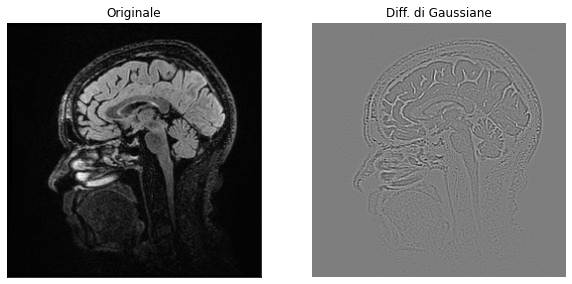

In [53]:
diff_gauss = np.array(dcm_img)

diff_gauss = scipy.ndimage.convolve(dcm_img,dog,mode='reflect')

axes = plot_images([dcm_img, diff_gauss],labels=['Originale', 'Diff. di Gaussiane'])

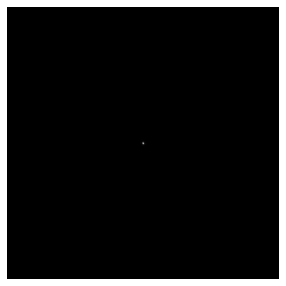

In [3]:
import numpy.fft as ft
#from scipy.fft import ftt2, ifft2, fftshift, ifftshift

# Effettuiamo il pad della nostra immagine
(padr, padc) = (dcm_img.shape[0]//2, dcm_img.shape[1]//2)

padded_img = np.pad(dcm_img,(padr, padc))

fft_image = ft.fft2(padded_img)

fft_image = ft.fftshift(fft_image)

axes = plot_images([(fft_image.real**2 + fft_image.imag**2)])

In [4]:
def low_pass(cutoff, shape):

    h = np.zeros(shape)

    squaredcutoff = cutoff ** 2

    for i in range(shape[0]):
        for j in range(shape[1]):

            squaredi = i**2
            squaredj = j**2
            squared_r_i = (shape[0]-i)**2
            squared_c_j = (shape[1]-j)**2

            if squaredi + squaredj <= squaredcutoff or\
               squaredi + squared_c_j <= squaredcutoff or\
               squaredj + squared_r_i <= squaredcutoff or\
               squared_r_i + squared_c_j <= squaredcutoff:

               np.put(h,i*shape[1]+j,1)

    h = ft.fftshift(h)
    
    return h



In [5]:
h = low_pass(50,fft_image.shape)

fft_image.real = h * fft_image.real
fft_image.imag = h * fft_image.imag

fft_image = ft.ifftshift(fft_image)

filtered_image = ft.ifft2(fft_image)

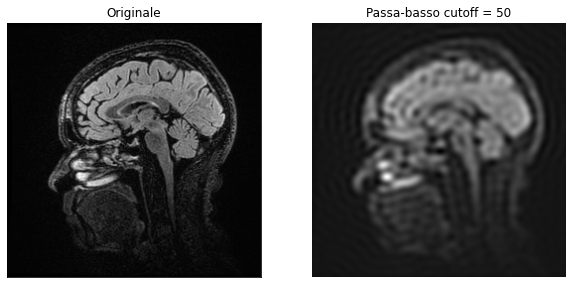

In [7]:
crop = filtered_image.real[padr:filtered_image.shape[0] - 1 - padr,padc:filtered_image.shape[1] - 1 - padc]

axes = plot_images([dcm_img, crop],labels=['Originale', 'Passa-basso cutoff = 50'])